In [1]:
import os
os.getcwd()

'/home/tmb/proj/ocropus4/training/g1000'

In [2]:
[global]
display = 10
limit = 10
multiplier = 1000
maxextract = 1000 * multiplier
nwordtrain = 1000 * multiplier
nsegtrain = 200 * multiplier
nrottrain = 1000 * multiplier
dataurl = 'http://storage.googleapis.com/ocropus4/Volume_0000.tar'

In [3]:
[download]
input: []
output: 'Volume_0000.tar'
sh: expand=True
    curl {dataurl} > Volume_0000.tar

In [4]:
%sosrun download

INFO: Running download :

INFO: download (index=0) is ignored due to saved signature

INFO: download output: Volume_0000.tar

INFO: Workflow download (ID=we3ba128f553f9d2a) is ignored with 1 ignored step.

In [5]:
[binarize]
input: 'Volume_0000.tar'
output: 'raw.tar'
sh: expand=True
    vocropus nlbin binarize Volume_0000.tar --output raw.tar

In [6]:
%sosrun binarize

INFO: Running binarize :

INFO: binarize (index=0) is ignored due to saved signature

INFO: binarize output: raw.tar

INFO: Workflow binarize (ID=w842e1d2dac8c6d64) is ignored with 1 ignored step.

In [7]:
!rebuild=y ./dtess --help

Sending build context to Docker daemon  2.048kB
Step 1/5 : FROM ubuntu:20.04
 ---> f643c72bc252
Step 2/5 : RUN date
 ---> Using cache
 ---> 5331dfc33a69
Step 3/5 : RUN apt-get update && apt-get install -y tesseract-ocr-all
 ---> Using cache
 ---> 3c9154853045
Step 4/5 : RUN mkdir /work
 ---> Using cache
 ---> d848a1aab5f4
Step 5/5 : WORKDIR /work
 ---> Using cache
 ---> e2f85069c280
Successfully built e2f85069c280
Successfully tagged tess:latest
Usage:
  tesseract --help | --help-extra | --version
  tesseract --list-langs
  tesseract imagename outputbase [options...] [configfile...]

OCR options:
  -l LANG[+LANG]        Specify language(s) used for OCR.
NOTE: These options must occur before any configfile.

Single options:
  --help                Show this help message.
  --help-extra          Show extra help for advanced users.
  --version             Show version information.
  --list-langs          List available languages for tesseract engine.


In [8]:
[tess]
input: 'raw.tar'
output: 'tess.tar'
sh: expand=True
    rebuild=y dtess --help
    tarp proc -c $(pwd)/'dtess sample.nrm.jpg sample.tess -l eng hocr; rm -f sample.lines.png sample.pseg.png' {_input} -o {_output}.tar.temp
    mv {_output}.tar.temp {_output}

In [9]:
%sosrun tess

INFO: Running tess :

INFO: tess (index=0) is ignored due to saved signature

INFO: tess output: tess.tar

INFO: Workflow tess (ID=w485531c8c2223047) is ignored with 1 ignored step.

In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
figsize(12, 8)
import webdataset as wds
from itertools import islice

In [12]:
ds = wds.WebDataset("tess.tar").decode("rgb8")
sample = next(islice(ds, 33, 999))
print(sample.keys())
print(sample["tess.hocr"].decode("utf-8"))

dict_keys(['__key__', 'nrm.jpg', 'tess.hocr'])
<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
    "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en">
 <head>
  <title></title>
  <meta http-equiv="Content-Type" content="text/html;charset=utf-8"/>
  <meta name='ocr-system' content='tesseract 4.1.1' />
  <meta name='ocr-capabilities' content='ocr_page ocr_carea ocr_par ocr_line ocrx_word ocrp_wconf'/>
 </head>
 <body>
  <div class='ocr_page' id='page_1' title='image "sample.nrm.jpg"; bbox 0 0 1507 2131; ppageno 0'>
   <div class='ocr_carea' id='block_1_1' title="bbox 8 284 22 743">
    <p class='ocr_par' id='par_1_1' lang='eng' title="bbox 8 284 22 743">
     <span class='ocr_line' id='line_1_1' title="bbox 8 284 22 743; textangle 90; x_size 22.75; x_descenders 5.5; x_ascenders 5.75">
      <span class='ocrx_word' id='word_1_1' title='bbox 8 284 22 700; x_wconf

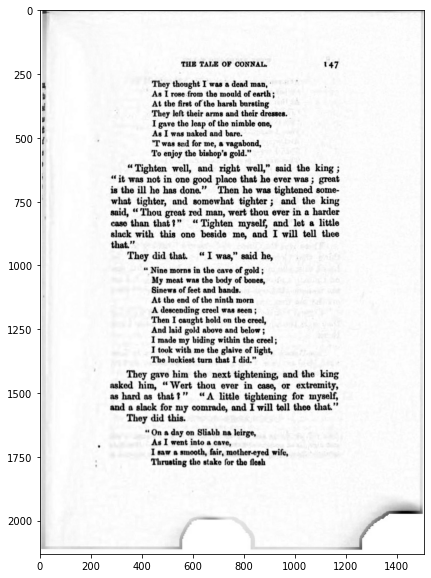

In [13]:
figsize(15, 10)
imshow(sample["nrm.jpg"])

In [14]:
[seg-data]
input: 'tess.tar'
output: 'book-seg.tar'
sh: expand=True
    vocropus extract-seg hocr2seg {_input} --output {_output}.temp --element ocrx_word --extensions 'nrm.jpg tess.hocr' --invert True \
        --show 100 --labels='1, 2, 3' --acceptable "10, 10, 500, 200" --maxcount {maxextract}
    mv {_output}.temp {_output}


In [15]:
%sosrun seg-data

INFO: Running seg-data :

INFO: seg-data (index=0) is ignored due to saved signature

INFO: seg-data output: book-seg.tar

INFO: Workflow seg-data (ID=wbe648207976f091e) is ignored with 1 ignored step.

dict_keys(['__key__', 'png', 'seg.png'])


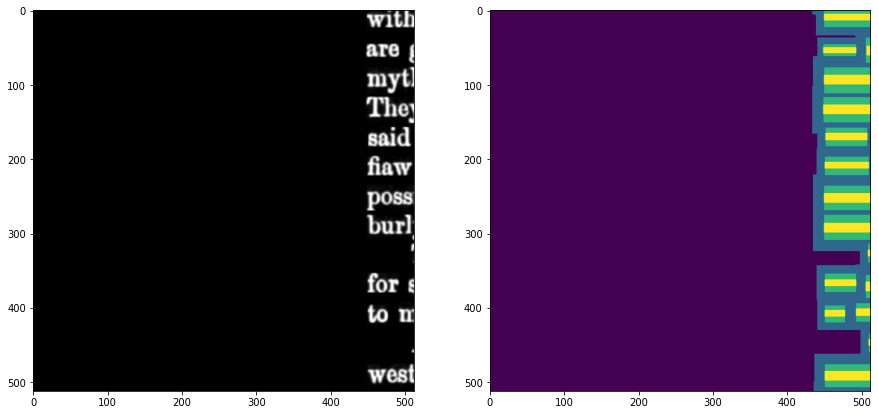

In [16]:
ds = wds.WebDataset("book-seg.tar").decode("rgb")
sample= next(islice(iter(ds), 500, 999))
print(sample.keys())
subplot(121); imshow(sample["png"])
subplot(122); imshow(sample["seg.png"][...,2])

In [17]:
[word-data]
input: 'tess.tar'
output: 'book-words.tar'
sh: expand=True
    vocropus extract-rec hocr2rec {_input} --output {_output}.temp --element ocrx_word --extensions 'nrm.jpg tess.hocr' \
        --bounds 10,10,500,100 --dictionary /usr/share/dict/american-english-huge --maxcount {maxextract} \
        --acceptable-conf 60.0
    mv {_output}.temp {_output}

In [18]:
%sosrun word-data

INFO: Running word-data :

INFO: word-data (index=0) is ignored due to saved signature

INFO: word-data output: book-words.tar

INFO: Workflow word-data (ID=w44572d06b6b484f9) is ignored with 1 ignored step.

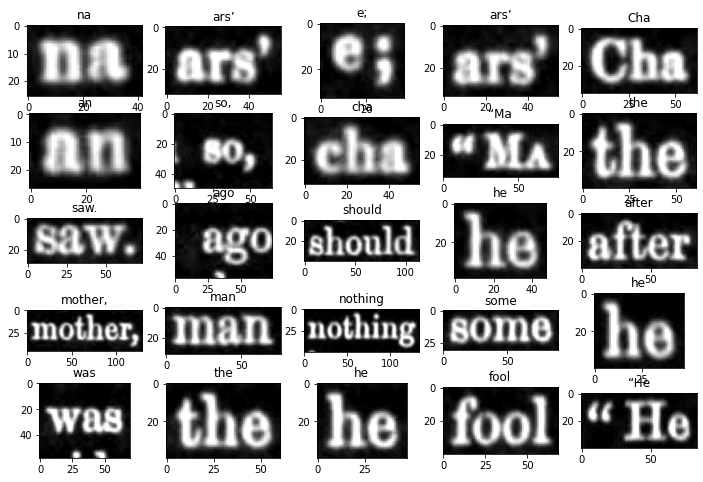

In [19]:
figsize(12, 8)
import webdataset as wds
from itertools import islice
ds = wds.WebDataset("book-words.tar").decode("rgb")
start = 55
for i, sample in enumerate(islice(iter(ds), start, start+250, 10)):
    subplot(5, 5, i+1)
    imshow(sample["png"])
    title(sample["txt"])

In [20]:
ds = wds.WebDataset("book-words.tar").decode("rgb")
alltext = [sample["txt"] for sample in ds]
    

In [21]:
from collections import Counter
counter = Counter()
for s in alltext: counter.update(s)

In [22]:
for c, n in counter.most_common():
    if len(str(c.encode("unicode_escape"))) > 4:
        print(f"""{c} {str(c.encode("unicode_escape")):10s} {n:10d}""")

” b'\\u201d'       1795
’ b'\\u2019'       1714
“ b'\\u201c'       1297
‘ b'\\u2018'        225
— b'\\u2014'         80
¢ b'\\xa2'            2
« b'\\xab'            2
\ b'\\\\'             1
® b'\\xae'            1
§ b'\\xa7'            1


In [23]:
[train-words]
input: 'book-words.tar'
output: 'wordtrain.sqlite3'
sh: expand=True
    export MPLBACKEND=TkAgg
    vocropus ocroline train {_input} --log-to {_output} --ntrain {nwordtrain} --display {display}

In [24]:
%sosrun train-words

INFO: Running train-words :

INFO: train-words (index=0) is ignored due to saved signature

INFO: train-words output: wordtrain.sqlite3

INFO: Workflow train-words (ID=w175b27f1a952f78a) is ignored with 1 ignored step.

In [25]:
[train-segs]
input: 'book-seg.tar'
output: 'segtrain.sqlite3'
sh: expand=True
    export MPLBACKEND=TkAgg
    vocropus ocroseg train {_input} --log-to {_output} --ntrain {nsegtrain} --display {display}

In [26]:
%sosrun train-segs

INFO: Running train-segs :

INFO: train-segs (index=0) is ignored due to saved signature

INFO: train-segs output: segtrain.sqlite3

INFO: Workflow train-segs (ID=w43b9f8771bd26653) is ignored with 1 ignored step.

In [41]:
[train-rot]
input: 'tess.tar'
output: 'rottrain.sqlite3'
sh: expand=True
    vocropus ocrorot train-rot {_input} --output {_output} --nsamples {nrottrain} --replicate 8 --num-workers 8 --extensions nrm.jpg


In [42]:
%sosrun train-rot

INFO: Running train-rot :

No LSB modules are available.
No LSB modules are available.
Sequential(
  (0): CheckSizes((2, 128), (1, 512), (256, 256), (256, 256))
  (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Conv2

INFO: train-rot output: rottrain.sqlite3

INFO: Workflow train-rot (ID=w389214631c252401) is executed successfully with 1 completed step.

In [33]:
[train-skew]
input: 'tess.tar'
output: 'skewtrain.sqlite3'
sh: expand=True
    vocropus ocrorot train-skew {_input} --output {_output} --nsamples {nrottrain} --replicate 8 --num-workers 8 --extensions 'nrm.jpg'


In [36]:
!vocropus ocrorot train-skew --help

Usage: ocrorot.py train-skew [OPTIONS] URLS...

  Trains either skew (=small rotation) or scale models.

Arguments:
  URLS...  [required]

Options:
  --nsamples INTEGER          [default: 1000000]
  --num-workers INTEGER       [default: 8]
  --bins TEXT                 [default: np.linspace(-0.1, 0.1, 21)]
  --alpha TEXT                [default: -0.1, 0.1]
  --scale TEXT                [default: 0.5, 2.0]
  --replicate INTEGER         [default: 1]
  --bs INTEGER                [default: 64]
  --prefix TEXT               [default: skew]
  --lrfun TEXT                [default: 0.3**(3+n//5000000)]
  --do-scale / --no-do-scale  [default: False]
  --output TEXT               [default: ]
  --limit INTEGER             [default: -1]
  --model TEXT                [default: page_skew_210113]
  --extensions TEXT           [default: bin.png;nrm.png;image.png;framed.png;p
                              age.png;png;page.jpg;jpg;jpeg]

  --help                      Show this message and exit.


In [37]:
%sosrun train-skew

INFO: Running train-skew :

No LSB modules are available.
No LSB modules are available.
Sequential(
  (0): CheckSizes((2, 128), (1, 512), (256, 256), (256, 256))
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Spectrum-logplus1
  (5): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Reshape(0, [1, 2, 3])
  (9): Linear(in_features=262144, out_features=128, bias=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=21, bias=True)
  (13): CheckSizes((2, 128), (21, 21))
)
# epoch 0
64 3.1341116428375244 0.026999999999999996
8192 1.6240032196044922 0.026999999999999996
15552 1.2511202037334441 0.026999999999999996
Traceback (most recent call last):
  File "/usr/lib/python

RuntimeError: Workflow exited with code 1

In [31]:
[train-scale]
input: 'tess.tar'
output: 'scaletrain.sqlite3'
sh: expand=True
    vocropus ocrorot train-scale {_input} --output {_output} --nsamples {nrottrain} --replicate 8 --num-workers 8


In [32]:
%sosrun train-scale

INFO: Running train-scale :

No LSB modules are available.
No LSB modules are available.
Sequential(
  (0): CheckSizes((2, 128), (1, 512), (256, 256), (256, 256))
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Spectrum-logplus1
  (5): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Reshape(0, [1, 2, 3])
  (9): Linear(in_features=262144, out_features=128, bias=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=21, bias=True)
  (13): CheckSizes((2, 128), (21, 21))
)
# epoch 0
Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", l

RuntimeError: Workflow exited with code 1